In [5]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import covid_19_shared

'''
https://data.cdc.gov/NCHS/Weekly-Counts-of-Deaths-by-State-and-Select-Causes/muzy-jte6
'''

def obtain_reported_deaths():
    reported_data = covid_19_shared.loadJHUData("US", True)
    

    reported_data.drop(['Confirmed', 'Recovered'], inplace=True, axis=1)
    
    # pad it with zeroes at the beginning of the year
    idx = pd.date_range(start=pd.Timestamp('2020-01-01'), end=reported_data.index[-1], freq='D')
    reported_data = reported_data + pd.DataFrame(
        {'Dead' : [0] * len(idx)}
        , index=pd.date_range(start=pd.Timestamp('2020-01-01')
                              , end=reported_data.index[-1], freq='D')
    )

    reported_data.Dead = reported_data.Dead.fillna(0).astype('int64')
    
    reported_covid_deaths = (reported_data.Dead - reported_data.Dead.shift(1)).dropna().resample('1W-SAT').sum()
    df = pd.DataFrame({"Week Ending" :  reported_covid_deaths.index.strftime('%Y-%m-%d')
                      , "Reported COVID-19 Deaths" : reported_covid_deaths.astype('int64')
                    })
    df.insert(0, 'Week', range(1, len(df.index) + 1))
    df = df.set_index('Week')
    return df


def proc_data(df):
    df = df[df["Jurisdiction of Occurrence"] == "United States"]
    df = df[["MMWR Year", "MMWR Week", "All Cause"]]
    df.columns = ["Year", "Week", "NumDeaths"]
    return df
    
def obtain_deaths_count_before_2019():
    df = pd.read_csv("https://data.cdc.gov/api/views/3yf8-kanr/rows.csv")
    df.columns = pd.Series(df.columns).str.replace("  ", " ")
    
    return proc_data(df)

def obtain_deaths_count_for_2019_and_2020():
    # Read from URL
    df = pd.read_csv("https://data.cdc.gov/api/views/muzy-jte6/rows.csv")
    df.columns = pd.Series(df.columns).str.replace("  ", " ")
    return proc_data(df)
 
def get_excess_deaths():
    
    df_2019_20 = obtain_deaths_count_for_2019_and_2020()
    

    df_2019 = df_2019_20[df_2019_20["Year"] == 2019].set_index("Week")[["NumDeaths"]]
    df_2020 =  df_2019_20[df_2019_20["Year"] == 2020].set_index("Week")[["NumDeaths"]]

    excess_deaths_df = df_2020

    diff = (df_2020.NumDeaths - df_2019.NumDeaths).dropna().array
    excess_deaths_df.loc[:, 'ExcessDeaths_vs_2019'] = diff
    return excess_deaths_df



In [6]:
# Load all data
reported_covid_deaths = obtain_reported_deaths()
excess_deaths_df = get_excess_deaths()



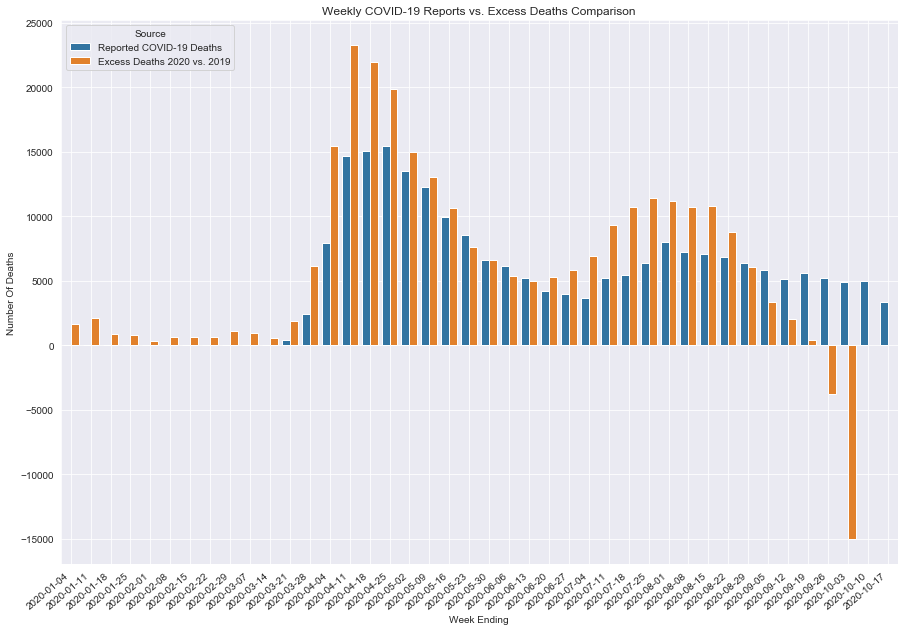

Reported COVID-19 Deaths      217,692.0
Excess Deaths 2020 vs. 2019   246,469.0
dtype: float64


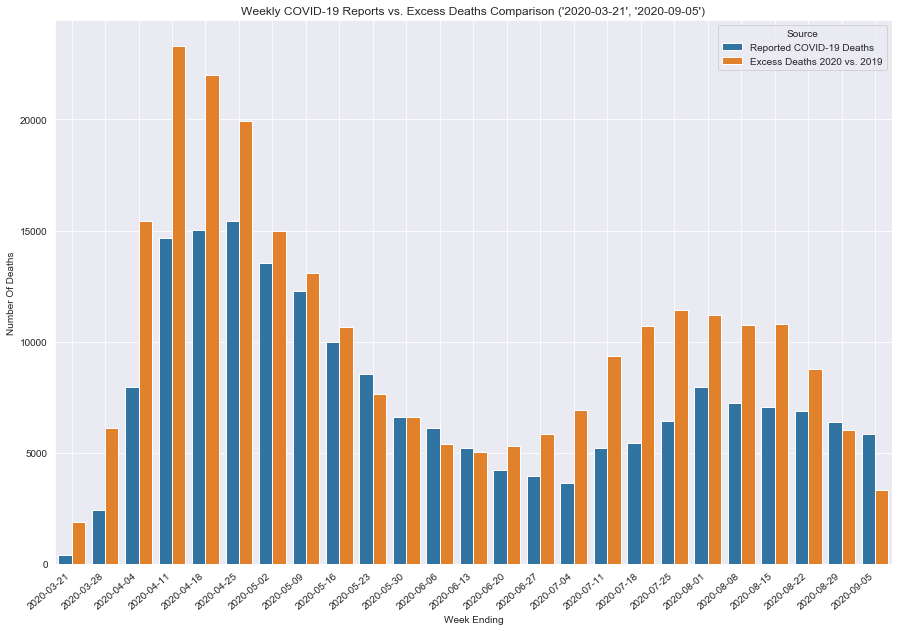

Reported COVID-19 Deaths      188,494.0
Excess Deaths 2020 vs. 2019   252,549.0
dtype: float64


In [7]:
def draw_chart(df: pd.DataFrame, plot_title: str):
    
    plt.figure(figsize = (15,10))
    df.plot(kind='bar'
            , stacked=False
            , figsize=(14, 6)
            , legend=True
            , grid = True
            , width = 0.9
            , color = ['darkred', 'darkblue', 'darkgreen']
            , title = plot_title
            )
    plt.show()
    
def show_result(reported_deaths : pd.DataFrame
                , excess_deaths : pd.DataFrame
               , **kwargs):
    
    def splice(df, date_interval):
        dt1, dt2 = date_interval
        df1 = df[df["Week Ending"] >= dt1]
        return df1[df1["Week Ending"] <= dt2] if dt2 is not None else df1

    df = reported_deaths.copy()
    if "ExcessDeaths_vs_2019" in excess_deaths:
        df["Excess Deaths 2020 vs. 2019"] =  excess_deaths.ExcessDeaths_vs_2019.astype('int64')
    if "ExcessDeaths_vs_Predicted" in excess_deaths:
        df["Excess Deaths 2020 vs. Predicted"] =   excess_deaths.ExcessDeaths_vs_Avg.astype('int64')

    plot_title = "Weekly COVID-19 Reports vs. Excess Deaths Comparison"
    if 'date_interval' in kwargs:
        df = splice(df, kwargs['date_interval'])
        plot_title = f"{plot_title} {kwargs['date_interval']}"
    
    df = df.set_index("Week Ending")

    draw_chart(df, plot_title)
    print(df.sum())


def show_result2(reported_deaths : pd.DataFrame
                , excess_deaths : pd.DataFrame
               , **kwargs):
    
    def splice(df, date_interval):
        dt1, dt2 = date_interval
        df1 = df[df["Week Ending"] >= dt1]
        return df1[df1["Week Ending"] <= dt2] if dt2 is not None else df1

    df = reported_deaths.copy()
    if "ExcessDeaths_vs_2019" in excess_deaths:
        df["Excess Deaths 2020 vs. 2019"] =  excess_deaths.ExcessDeaths_vs_2019.astype('int64')
    if "ExcessDeaths_vs_Predicted" in excess_deaths:
        df["Excess Deaths 2020 vs. Predicted"] =   excess_deaths.ExcessDeaths_vs_Avg.astype('int64')

    plot_title = "Weekly COVID-19 Reports vs. Excess Deaths Comparison"
    if 'date_interval' in kwargs:
        df = splice(df, kwargs['date_interval'])
        plot_title = f"{plot_title} {kwargs['date_interval']}"
    
    df = df.set_index("Week Ending")

    draw_chart2(df, plot_title)
    print(str(pd.options.display))
    pd.options.display.float_format = '{:,}'.format
    print(df.sum().astype('float'))

def draw_chart2(df, plot_title):
    import seaborn as sns
    sns.set_style("darkgrid")

    df = df.reset_index()
    tidy = df.melt(id_vars="Week Ending", var_name="Source", value_name="Number Of Deaths")
#     print(tidy)
    
    fig, ax = plt.subplots(figsize = (15,10))
    sns.barplot(data=tidy, x="Week Ending", y="Number Of Deaths", hue="Source")
    plt.title(plot_title)
    ax.grid(b=True)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha='right')
    plt.show()
    
# show_result(reported_covid_deaths, excess_deaths_df)
show_result2(reported_covid_deaths, excess_deaths_df)
show_result2(reported_covid_deaths, excess_deaths_df, date_interval = ('2020-03-21', '2020-09-05'))


In [8]:
def get_excess_deaths2():
    df_2019_20 = obtain_deaths_count_for_2019_and_2020()
    

    df_2019 = df_2019_20[df_2019_20["Year"] == 2019].set_index("Week")[["NumDeaths"]]
    df_2020 =  df_2019_20[df_2019_20["Year"] == 2020].set_index("Week")[["NumDeaths"]]

    excess_deaths_df = df_2020

    diff = (df_2020.NumDeaths - df_2019.NumDeaths).dropna().array
    excess_deaths_df.loc[:, 'ExcessDeaths_vs_2019'] = diff

    # Calculate weekly mean for 2014-2019
    # 
    df_before_2019 = obtain_deaths_count_before_2019()
    df_before_2020 = pd.concat([df_before_2019,  df_2019_20[df_2019_20["Year"] == 2019]])

    df_by_year = dict()
    previous_years = range(2014, 2020)
    for year in previous_years:
        df_by_year[year] = df_before_2020[df_before_2020["Year"] == year].set_index("Week")[["NumDeaths"]]

    series = pd.Series([0] * len(df_by_year[2019].index), index=df_by_year[2019].index, dtype='int64')
    for year in previous_years:
        series = series + df_by_year[year]["NumDeaths"]
    avg_series = series / len(previous_years)
    avg_series = avg_series.dropna()

    diff = (df_2020.NumDeaths - avg_series).dropna().array
    excess_deaths_df.loc[:, 'ExcessDeaths_vs_Predicted'] = diff
    return excess_deaths_df

